In [1]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
plt.style.use('classic')
font = {'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
def sum_throughput(trace):
    s = []
    for t in trace:
        trace = pd.read_table(t, header=None, sep=(","),names=("xseconds", "rate"))
        if len(s) == 0: s = trace
        else: s += trace
    return s

def format_graph(label):
    ax.set_ylim(0, 3)
    ax.set_yticks([1, 2, 3])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f k'))
    ax.set_xticks([])
    ax.set_ylabel("ops/second")
    ax2 = ax.twinx()
    ax2.set_yticks([])
    ax2.set_ylabel(label, fontsize=12, rotation=60, labelpad=25)
    
def graph_it(ax, foreground, background):
    s = sum_throughput(foreground)
    ax.plot(range(0, len(s['rate'])*6, 6), s['rate']/1000, 
    'r-', marker='x', linewidth=2.0, label="Sequencer 1")

    t = sum_throughput(background)
    ax.plot(range(0, len(t['rate'])*6, 6), t['rate']/1000, 
        'b-', marker='o', linewidth=2.0, label="Sequencer 2")

    ax.plot(range(0, len(t['rate'])*6, 6), (t['rate']+s['rate'])/1000, 
        '--', color='black', linewidth=2.0, label="Sum")

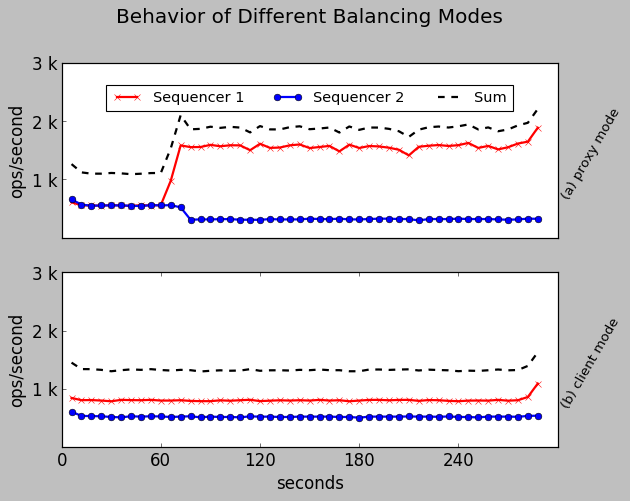

In [3]:
fig = plt.figure()

###
ax = fig.add_subplot(211)
graph_it(ax, glob.glob("wave1-foreground-*throughput.csv"), glob.glob("wave1-issdm-*throughput.csv"))
format_graph("(a) proxy mode")
ax.set_title("Behavior of Different Balancing Modes", y=1.2)

ax = fig.add_subplot(212)
graph_it(ax, glob.glob("wave2-foreground-*throughput.csv"), glob.glob("wave2-issdm-*throughput.csv"))
format_graph("(b) client mode")

#ax = fig.add_subplot(212)
#graph_it(ax, glob.glob("proxy-all-foreground-*throughput.csv"), glob.glob("proxy-all-issdm-*throughput.csv"))
#format_graph("(b) proxy mode")

#ax = fig.add_subplot(212)
#graph_it(ax, glob.glob("proxy2wave-all-foreground-*throughput.csv"), glob.glob("proxy2wave-all-issdm-*throughput.csv"))
#format_graph("(d) seq. mode")

###
ax.set_xlabel("seconds")
ax.set_xticks(range(0, 300, 60))
lgd = ax.legend(loc='center', ncol=3, fontsize=13, bbox_to_anchor=(0.5,2.0))
plt.savefig('mantle-mode-behavior.png', dpi=300, bbox_inches='tight')

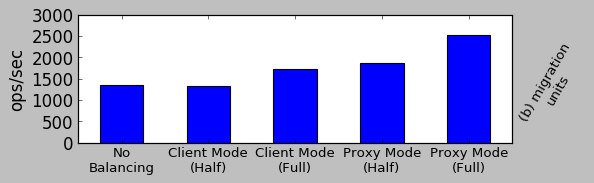

In [5]:
# Get the sum of all the 1 sequencer experiment throughputs
df = sum_throughput(glob.glob("../../mds-zlog-seq-migrate-redux-baseline/results-singlenode-run0-baseline/singlenode-run0-baseline*throughput.csv"))
df.columns = ['seconds', 'No\nBalancing']

name = "Client Mode\n(Half)"
s = sum_throughput(glob.glob("wave2-*throughput.csv"))
s.columns = ['seconds', name]
df = pd.concat([df, s[name]], axis=1)

name = "Client Mode\n(Full)"
s = sum_throughput(glob.glob("proxy2wave-all-*throughput.csv"))
s.columns = ['seconds', name]
df = pd.concat([df, s[name]], axis=1)

name = "Proxy Mode\n(Half)"
s = sum_throughput(glob.glob("wave1-*throughput.csv"))
s.columns = ['seconds', name]
df = pd.concat([df, s[name]], axis=1)

name = "Proxy Mode\n(Full)"
s = sum_throughput(glob.glob("proxy-all-*throughput.csv"))
s.columns = ['seconds', name]
df = pd.concat([df, s[name]], axis=1)

# Trim off the unstable throughputs
df = df.drop(df.index[range(0, 18)])
df = df.drop(df.index[range(len(df)-5, len(df))])
ax = df.mean().plot.bar(figsize=(7,2))
#ax.set_title("Performance of Different Balancing Modes", y=1.1)
ax.set_ylabel("ops/sec")
plt.xticks(rotation='horizontal', fontsize=12)
ax2 = ax.twinx()
ax2.set_yticks([])
ax2.set_ylabel("(b) migration\nunits", fontsize=12, rotation=60, labelpad=25)
plt.savefig('mantle-mode-performance.png', dpi=300, bbox_inches='tight')